In [2]:
from pytesseract import Output
from imutils.object_detection import non_max_suppression
import pytesseract
import argparse
import cv2
import os
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\newgh\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
import imutils
from sklearn.cluster import AgglomerativeClustering
import face_recognition

In [3]:
def decode_predictions(scores, geometry,min_confidence):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue
            
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    return (rects, confidences)

In [4]:
def model_based_ROI_extraction(image):
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    net = cv2.dnn.readNet(east_path)
    blob = cv2.dnn.blobFromImage(image, 1.0, (width, height),(128, 128, 128), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    (rects, confidences) = decode_predictions(scores, geometry,min_confidence)
    boxes = rects
    return boxes
def drawROIs(image,boxes):
    im = image.copy()
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,0,0),thickness)
    return im
def white_patch(image, boxes):
    im = np.zeros(image.shape)
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,255,255),-1)
    return im
def visualize_output(modelbinary,model):
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(modelbinary)
    plt.title('binary by model')
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(model)
    plt.title('model')
    plt.axis('off')

In [5]:
current = os.getcwd()
east_path = os.path.join(current,"frozen_east_text_detection.pb")
width = 1024
height = 1024
min_confidence = 0.5
thickness = 2
images = ["testing.jpg","testing2.png"]

In [6]:
def area(x1,y1,x2,y2):
    return (x2-x1)*(y2-y1)

In [7]:
def inter(b1,b2):
    (sx1, sy1 , ex1, ey1) = b1
    a1 = area(sx1, sy1 , ex1, ey1)
    (sx2, sy2 , ex2, ey2) = b2
    a2 = area(sx2, sy2 , ex2, ey2)
    isx = max(sx1,sx2)
    isy = max(sy1,sy2)
    iex = min(ex1,ex2)
    iey = min(ey1,ey2)
    i = area(isx,isy,iex,iey)
    return i

In [8]:
def check_ious_inters(boxes):
    for i in range(len(boxes)-1):
        for j in range(i+1,len(boxes)):
            if inter(boxes[i],boxes[j]) > 0:
                return True
    return False

In [9]:
def fuse(b1,b2):
    (sx1,sy1,ex1,ey1) = b1
    (sx2,sy2,ex2,ey2) = b2
    sx = min(sx1,sx2)
    sy = min(sy1,sy2)
    ex = max(ex1,ex2)
    ey = max(ey1,ey2)
    box = (sx,sy,ex,ey)
    return box

In [10]:
def fuse_lines(boxes):
    while(check_ious_inters(boxes)):
        print(len(boxes),end=" ==> ")
        i = 0
        while(i<len(boxes)-1):
            j=i+1
            while(j<len(boxes)):
                b1 = boxes[i]
                b2 = boxes[j]
                if inter(b1,b2) > 0:
                    box=fuse(b1,b2)
                    boxes.remove(b1)
                    boxes.remove(b2)
                    boxes.append(box)
                j+=1
            i+=1
    return boxes

In [20]:
def cluster_and_draw(image,trad_boxes,distance_thresh = 20):
    snip = image.copy()
    yCoords = [(0, c[1]) for c in trad_boxes]
    clustering = AgglomerativeClustering(
        n_clusters=None,
        affinity="manhattan",
        linkage="complete",
        distance_threshold=distance_thresh)
    clustering.fit(yCoords)
    sortedClusters = []
    for l in np.unique(clustering.labels_):
        idxs = np.where(clustering.labels_ == l)[0]
        avg = np.average([trad_boxes[i][1] for i in idxs])
        sortedClusters.append((l, avg))
    sortedClusters.sort(key=lambda x: x[1])
    for (l, _) in sortedClusters:
        idxs = np.where(clustering.labels_ == l)[0]
        yCoords = [trad_boxes[i][1] for i in idxs]
        sortedIdxs = idxs[np.argsort(yCoords)]
        boxes = [b for b in trad_boxes if trad_boxes.index(b) in sortedIdxs]
        print(len(idxs),end=" ==> ")
        boxes = fuse_lines(boxes)
        print(len(boxes))
        color = np.random.randint(0, 200, size=(3,), dtype="int")
        color = [int(c) for c in color]
        for box in boxes:
            (startX, startY, endX, endY) = box
            cv2.rectangle(snip, (startX, startY), (endX, endY), color, thickness)
    return snip

In [12]:
def close_up(image_path):
    image = face_recognition.load_image_file(image_path)
    height,width = image.shape[:2]
    face_locations = face_recognition.face_locations(image)
    m = 0
    main_face = face_locations[0]
    for face in face_locations:
        top, right, bottom, left = face
        area = abs(top - bottom) * abs(right - left)
        if area > m :
            m = area
            main_face = face
    top, right, bottom, left = main_face
    image_closeup = image[0:bottom,right:width]
    return (image_closeup,image)

(-0.5, 1023.5, 1023.5, -0.5)

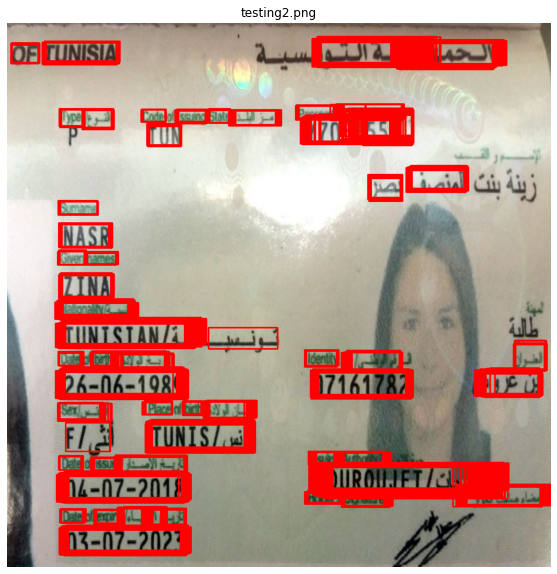

In [13]:
im = images[1]
im_path = os.path.join(current,im)
(image,original) = close_up(im_path)
image = np.array(Image.fromarray(image).resize((width,height),resample=PIL.Image.BICUBIC))
model_boxes = model_based_ROI_extraction(image)
model = drawROIs(image,model_boxes)
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(model)
plt.title(im)
plt.axis('off')

In [21]:
image = cluster_and_draw(image,model_boxes, distance_thresh = 30)

430 ==> 430 ==> 19 ==> 6 ==> 4 ==> 3
231 ==> 231 ==> 31 ==> 12 ==> 6 ==> 5
214 ==> 214 ==> 14 ==> 5 ==> 3 ==> 2
138 ==> 138 ==> 12 ==> 4 ==> 2
42 ==> 42 ==> 5 ==> 2 ==> 1
69 ==> 69 ==> 6 ==> 2 ==> 1
49 ==> 49 ==> 8 ==> 3 ==> 2 ==> 1
80 ==> 80 ==> 6 ==> 2 ==> 1
91 ==> 91 ==> 6 ==> 2 ==> 1
214 ==> 214 ==> 8 ==> 3 ==> 2
157 ==> 157 ==> 24 ==> 9 ==> 6 ==> 5
558 ==> 558 ==> 22 ==> 8 ==> 5 ==> 4 ==> 3
108 ==> 108 ==> 16 ==> 8 ==> 6 ==> 5 ==> 4
228 ==> 228 ==> 9 ==> 3 ==> 2
170 ==> 170 ==> 18 ==> 7 ==> 4 ==> 3
558 ==> 558 ==> 21 ==> 6 ==> 3 ==> 2
135 ==> 135 ==> 14 ==> 5 ==> 3 ==> 2
79 ==> 79 ==> 10 ==> 4 ==> 2
241 ==> 241 ==> 7 ==> 3 ==> 2 ==> 1


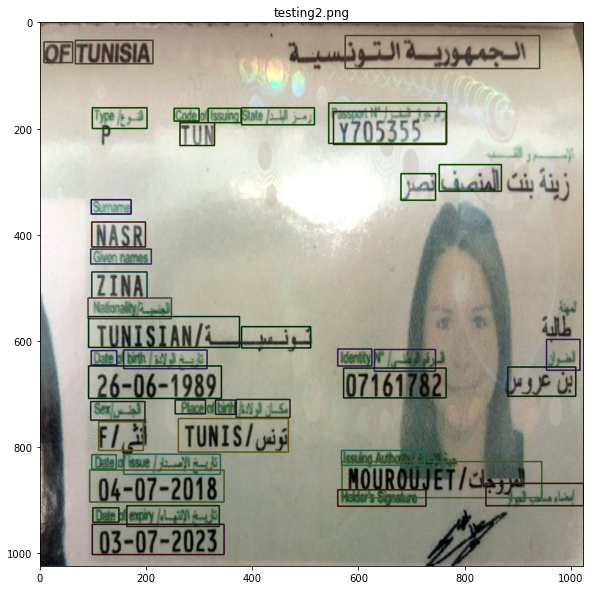

In [15]:
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 1
fig.add_subplot(rows, columns, 1)
plt.title(im)
plt.imshow(image)
plt.show()

### east segmentation model keeps ignoring vital pieces of text like the arabic name and job

In [17]:
def show2(image1,image2):
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(image1)
    plt.title("image1")
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(image2)
    plt.title("image2")
    plt.axis('off')

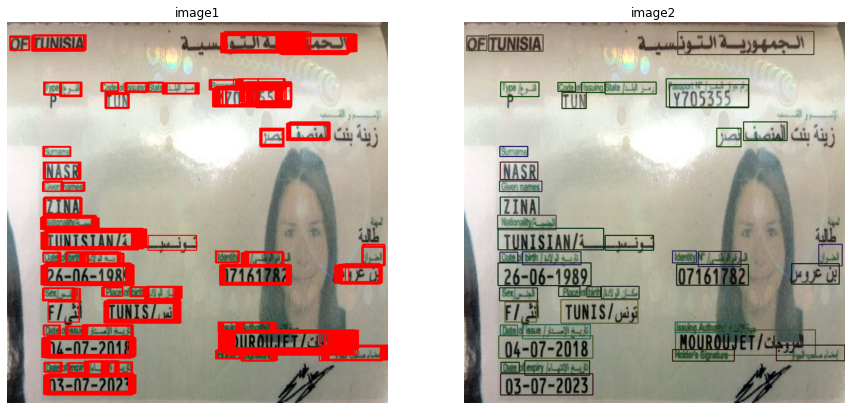

In [19]:
show2(model,image)